# Robust ML Testing (Tests Example)

This notebook shows several automatic tests which can be included within your ML pipeline in order to ensure robustness against bugs, drift or oversights.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from mercury.dataschema import DataSchema
from mercury.dataschema.feature import FeatType

from mercury.robust.data_tests import (
    SameSchemaTest, 
    DriftTest,
    LinearCombinationsTest,
    LabelLeakingTest,
    NoisyLabelsTest,
    CohortPerformanceTest
)

## Load Dataset

Here we will use the **Titanic** and **Tips** datasets in some of the robust tests. We will be manually altering it for running the different tests for showing how they can detect failures.


In [3]:
tips = sns.load_dataset("tips")

In [4]:
#titanic = Titanic().load()
titanic = sns.load_dataset("titanic")
isna_deck = titanic.deck.isna()
titanic['class'] = titanic['class'].astype(str)
titanic['deck'] = titanic['deck'].astype(str)
titanic['who'] = titanic['who'].astype(str)
titanic.loc[isna_deck, 'deck'] = np.nan

In [5]:
titanic.head(5)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


## Robust Test

Next, we show examples of different tests. You can follow the tutorial executing all the test or you can jump to the tests that you are more interested:

#### [Same Schema Test](#same_schema)
#### [Data Drift Test](#data_drift)
#### [Linear Combinations Test](#linear_combinations)
#### [Label Leaking Test](#label_leaking)
#### [Noisy Labels Test](#noisy_labels)
#### [Cohort Performance Test](#cohort_performance)
#### [Model Reproducibility Test](#model_reproducibility)
#### [Model Simplicity Test](#model_simplicity)
#### [Drift Resistance Test](#drift_resistance)
#### [Sample Leaking Test](#sample_leaking)
#### [Feature Checker Test](#feature_checker)

<a id="same_schema"></a>
### Same Schema Test example

This test ensures a dataset (or new batch of data) shares the same schema as an original dataset. If the schema of the new data changes, for any reason (e.g. errors/changes on ETL processes), the test will detect it and will fail.

In [6]:
titanic2 = titanic.copy() # Make an unaltered copy

For this test, we first need to have an already built **Mercury's `DataSchema`** object with the schema of the original dataset (e.g. training data). Note it doesn't need to be generated on every test, as it can also be serialized and loaded back.

In [7]:
# Schema of the original dataset
schma_reference = DataSchema().generate(titanic).calculate_statistics()

/Users/e055518/Library/Python/3.9/lib/python/site-packages/mercury/dataschema/feature.py:306: RuntimeWarning: INTEGER feature pclass converted to Categorical because percentage of unique values 0.003367003367003367 is lower than threshold 0.05611672278338945
  warnings.warn(
/Users/e055518/Library/Python/3.9/lib/python/site-packages/mercury/dataschema/feature.py:306: RuntimeWarning: INTEGER feature sibsp converted to Categorical because percentage of unique values 0.007856341189674524 is lower than threshold 0.05611672278338945
  warnings.warn(
/Users/e055518/Library/Python/3.9/lib/python/site-packages/mercury/dataschema/feature.py:306: RuntimeWarning: INTEGER feature parch converted to Categorical because percentage of unique values 0.007856341189674524 is lower than threshold 0.05611672278338945
  warnings.warn(


Create and execute this single test. It will pass because the original schema has not been altered

In [8]:
SameSchemaTest(titanic2, schma_reference).run()

/Users/e055518/Library/Python/3.9/lib/python/site-packages/mercury/dataschema/feature.py:306: RuntimeWarning: INTEGER feature pclass converted to Categorical because percentage of unique values 0.003367003367003367 is lower than threshold 0.05611672278338945
  warnings.warn(
/Users/e055518/Library/Python/3.9/lib/python/site-packages/mercury/dataschema/feature.py:306: RuntimeWarning: INTEGER feature sibsp converted to Categorical because percentage of unique values 0.007856341189674524 is lower than threshold 0.05611672278338945
  warnings.warn(
/Users/e055518/Library/Python/3.9/lib/python/site-packages/mercury/dataschema/feature.py:306: RuntimeWarning: INTEGER feature parch converted to Categorical because percentage of unique values 0.007856341189674524 is lower than threshold 0.05611672278338945
  warnings.warn(


Alter new dataset. We simulate we lose one of the columns... (however, this test will also check feature names and datatypes are the same)

In [9]:
titanic2 = titanic.drop('deck', axis=1)

As the schema of the new dataset has been changed, the test will fail

In [10]:
SameSchemaTest(titanic2, schma_reference).run()  # This will fail

/Users/e055518/Library/Python/3.9/lib/python/site-packages/mercury/dataschema/feature.py:306: RuntimeWarning: INTEGER feature pclass converted to Categorical because percentage of unique values 0.003367003367003367 is lower than threshold 0.05611672278338945
  warnings.warn(
/Users/e055518/Library/Python/3.9/lib/python/site-packages/mercury/dataschema/feature.py:306: RuntimeWarning: INTEGER feature sibsp converted to Categorical because percentage of unique values 0.007856341189674524 is lower than threshold 0.05611672278338945
  warnings.warn(
/Users/e055518/Library/Python/3.9/lib/python/site-packages/mercury/dataschema/feature.py:306: RuntimeWarning: INTEGER feature parch converted to Categorical because percentage of unique values 0.007856341189674524 is lower than threshold 0.05611672278338945
  warnings.warn(


FailedTestError: Features do not match. These ones are not present on both datasets ['deck']

<a id="data_drift"></a>
### Data Drift Test example

Again, for this test, we first need to have an already built Mercury's `DataSchema` object with the schema of the original dataset (e.g. training data). Note it doesn't need to be generated on every test, as it can also be serialized and loaded back.

In [11]:
schma_reference = DataSchema().generate(titanic).calculate_statistics()

First, run a test with no existing drift. It will pass...

In [12]:
test = DriftTest(titanic, schma_reference).run()

We now simulate several types of drift. Let's start with a drift on the `age` feature.

In [13]:
titanic2 = titanic.copy()
titanic2['age'] *= titanic2['age']  # quadratic relation

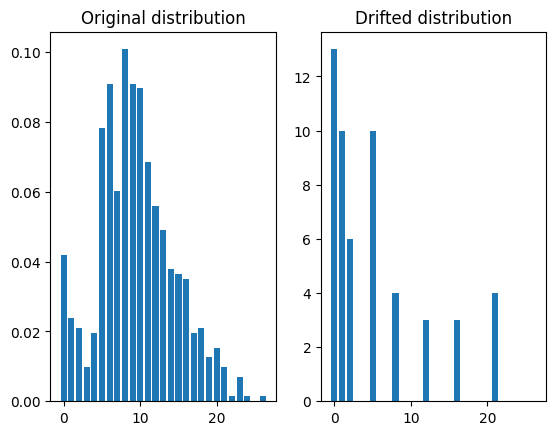

In [14]:
fig, ax = plt.subplots(1,2)

hist1 = schma_reference.feats['age'].stats['distribution']
hist2 = np.histogram(titanic2.loc[:, 'age'],
             range=(schma_reference.feats['age'].stats['min'], schma_reference.feats['age'].stats['max']),
             bins=len(schma_reference.feats['age'].stats['distribution'])
             )[0] #/ len(titanic2.loc[:, x])


ax[0].bar(list(range(0, len(hist1))), hist1)
ax[1].bar(list(range(0, len(hist2))), hist2)

ax[0].set_title('Original distribution')
ax[1].set_title('Drifted distribution');

In [15]:
DriftTest(titanic2, schma_reference).run()  # This will fail

FailedTestError: Test failed. Drift was detected on the following features: ['age']

Next, let's simulate we lose one of the categories from `sex`

In [16]:
titanic2 = titanic.copy()
titanic2['sex'] = 'male'   # We lose one of the categories

In [17]:
DriftTest(titanic2, schma_reference).run()  # This will fail

FailedTestError: Test failed. Drift was detected on the following features: ['sex']

<a id="linear_combinations"></a>
### Linear combinations Test example

This test searches linear combinations between your numerical features (only the continuous ones at the time of writing this tutorial).

Let's extract continuous features from the titanic dataset and run the test.

In [18]:
test_df = titanic.loc[:, schma_reference.continuous_feats].dropna()

In [19]:
test_df.head(2)

,age,fare
0,22.0,7.2500
1,38.0,71.2833


As these two features are independent, no linear combinations will be found, so the test will pass

In [20]:
LinearCombinationsTest(test_df).run()

Let's artificially generate a dataset with a column which is linearly dependent with `age`. This aims to serve as an example when we have a dataset with clear feature dependencies, which should be removed prior to model trainings.

In [21]:
test_df['combination'] = test_df['age'] * 2
LinearCombinationsTest(test_df).run()

FailedTestError: Test failed. Linear combinations for continuous features were encountered.

<a id="label_leaking"></a>
### Label leaking Test example

This test seeks for any strong relationship between any of the predictor variables and the target. If found, it fails.

Let us load the tips dataset and simulate a nonlinear relationship with the target.

In [22]:
from sklearn import preprocessing

In [23]:
tips = sns.load_dataset("tips")
tips['sex'] = tips['sex'].astype(str)
tips['smoker'] = tips['smoker'].astype(str)
tips['day'] = tips['day'].astype(str)
tips['time'] = tips['time'].astype(str)

for feat in ['sex', 'smoker', 'day', 'time']:
    tips.loc[:, feat] = preprocessing.LabelEncoder().fit_transform(tips.loc[:, feat])

tips.head(4)

/var/folders/kd/l44dx4nx06bc4wcs81jd6cr00000gq/T/ipykernel_47313/1709824187.py:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  tips.loc[:, feat] = preprocessing.LabelEncoder().fit_transform(tips.loc[:, feat])
/var/folders/kd/l44dx4nx06bc4wcs81jd6cr00000gq/T/ipykernel_47313/1709824187.py:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  tips.loc[:, feat] = preprocessing.LabelEncoder().fit_transform(tips.loc[:, feat])
/var/folders/kd/l44dx4nx06bc4wcs81jd6cr00000gq/T/ipykernel_47313/1709824187.py:8: DeprecationWarning: In a future version, `df

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,0,0,2,0,2
1,10.34,1.66,1,0,2,0,3
2,21.01,3.50,1,0,2,0,3
3,23.68,3.31,1,0,2,0,2


In this case, `injected` will be the target variable squared

In [24]:
tips['injected'] = tips['total_bill'] ** 2

We create and run the test

In [25]:
test = LabelLeakingTest(
    tips,
    label_name='total_bill',
    threshold = 0.05
)

In [26]:
test.run()

/Users/e055518/Library/Python/3.9/lib/python/site-packages/mercury/dataschema/feature.py:306: RuntimeWarning: INTEGER feature day converted to Categorical because percentage of unique values 0.01639344262295082 is lower than threshold 0.20491803278688525
  warnings.warn(
/Users/e055518/Library/Python/3.9/lib/python/site-packages/mercury/dataschema/feature.py:306: RuntimeWarning: INTEGER feature size converted to Categorical because percentage of unique values 0.02459016393442623 is lower than threshold 0.20491803278688525
  warnings.warn(


FailedTestError: Test failed because high importance features were detected: ['injected']. Check for possible target leaking.

Because the test failed, we can take a look at the `importances_` attribute. It is a dictionary with all the predictor features and their "relationship" to the target. 

This "relationship" is simply the result of a chosen metric whose best value is $1$ (by default: ROC-AUC for classification and $R^2$ for regression; although you can manually specify other metric via the `metric` parameter). Thus, if any of the features is too close to 1 ($> 1 - threshold$), the test will fail. The threshold can be configured via the `threshold` parameter, so using a higher threshold will require a higher importance on the feature to make the test fail.

*Note: Note that the chosen metric doesn't have to be the one you're optimizing. The purpose of this test is only to find strong relationships, so almost any metric will do the job.*

In [27]:
test.importances_

{'smoker': 0.007348133957009506,
 'sex': 0.020989442787269885,
 'day': 0.03343679742214034,
 'time': 0.033532057384179303,
 'size': 0.3706735216893777,
 'tip': 0.511194450488601,
 'injected': 0.9749336284220832}

Internally, this test uses a selection method based on tree models. After the test is done, you can inspect the fitted object with the following:

In [28]:
test._selector.feature_importances

{'features': array([2, 1, 3, 4, 5, 0, 6]),
 'metrics': [0.007348133957009506,
  0.020989442787269885,
  0.03343679742214034,
  0.033532057384179303,
  0.3706735216893777,
  0.511194450488601,
  0.9749336284220832]}

<a id="noisy_labels"></a>
### Noisy Labels Test example

This test looks at the labels of the dataset and fails if there are a high number of samples where the labels are considered noisy. Noisy labels can happen for several reasons. For example, they can occur due to errors in the labelling process, or because some samples might not belong to just one specific label.

<b> Tabular Dataset: Titanic </b>

Let's first use the test in the titanic dataset. We will keep only some columns and discard rows with null values:

In [29]:
train_df = titanic[["survived", "pclass", "sex", "age", "fare", "who"]].dropna().copy()
train_df.head()

,survived,pclass,sex,age,fare,who
0,0,3,male,22.0,7.2500,man
1,1,1,female,38.0,71.2833,woman
2,1,3,female,26.0,7.9250,woman
3,1,1,female,35.0,53.1000,woman
4,0,3,male,35.0,8.0500,man


Now we create the `NoisyLabelsTest`. 

We specify the dataset, the label name and a threshold of 0.25, which means that if more than 25% are detected as noisy then the text will fail. 

We also specify some parameters for the algorithm detecting the noisy labels (internally, it uses the test uses the [cleanlab](https://cleanlab.readthedocs.io/en/latest/) library). In this case, we specify that the algorithm will use a Random Forest to compute the probabilities (if we left the default configuration it uses a Logistic Regression). You can see more configurable parameters in the documentation.

Another important point is that the dataset contains string features. In this case, as we do not specify the `preprocessor` argument, then the test will use a `OneHotEncoding` to encode these features. Alternatively, it is possible to pass a `preprocessor` to apply to the features.

In [30]:
from sklearn.ensemble import RandomForestClassifier

label_issues_args = dict(
    clf=RandomForestClassifier(max_depth=4)
)

test = NoisyLabelsTest(
    train_df,
    label_name='survived',
    threshold=0.25,
    label_issues_args=label_issues_args
)
test.run()

/Users/e055518/Library/Python/3.9/lib/python/site-packages/mercury/dataschema/feature.py:306: RuntimeWarning: INTEGER feature pclass converted to Categorical because percentage of unique values 0.004201680672268907 is lower than threshold 0.0700280112044818
  warnings.warn(


The test has passed. We can also look at the percentage of labels detected as noisy looking at the property `rate_issues_`:

In [31]:
test.rate_issues_

0.08683473389355742

Now, let's introduce noise in the labels and see if the test keeps passing:

In [32]:
train_df["survived"] = np.random.choice([0,1], replace=True, size=len(train_df))

In [33]:
label_issues_args = dict(
    clf=RandomForestClassifier(max_depth=4)
)

test = NoisyLabelsTest(
    train_df,
    label_name='survived',
    threshold=0.25,
    label_issues_args=label_issues_args
)
test.run()

/Users/e055518/Library/Python/3.9/lib/python/site-packages/mercury/dataschema/feature.py:306: RuntimeWarning: INTEGER feature pclass converted to Categorical because percentage of unique values 0.004201680672268907 is lower than threshold 0.0700280112044818
  warnings.warn(


FailedTestError: Test failed. High level of noise detected in labels. Percentage of labels with noise: 0.4803921568627451

We see that now the test fails since the percentage of labels detected with noise is higher than the threshold

<b> Text Dataset: Banking Intents </b>

The test can also be used with text datasets.

We will use it with the banking intents dataset, which contains short customer queries classified under 77 possible labels. This dataset was used in [[1]](#[1])








In [34]:
path_dataset = "./data/bankintents/"
train_df = pd.read_csv(path_dataset + "train.csv")
test_df = pd.read_csv(path_dataset + "test.csv")
categories_df = pd.read_json(path_dataset + "categories.json")
train_df = train_df.sample(frac=1, random_state=342)  # shuffle

In [35]:
train_df.head()

,text,category,set,category_id,id
9695,how do i set up my apple pay watch to connect ...,apple_pay_or_google_pay,train,74,9695
3369,Why isn't my balance updating after depositing...,balance_not_updated_after_cheque_or_cash_deposit,train,26,3369
377,How do you decide what your exchange rates are?,exchange_rate,train,2,377
4669,I see a direct debit transaction that I didn't...,direct_debit_payment_not_recognised,train,37,4669
7815,How can I create another card linked to this a...,getting_spare_card,train,60,7815


When using a text dataset we need to specify the `text_col` parameter, which is the column containing the text in the dataframe. If we do not specify a preprocessor, a `CountVectorizer` is created internally to convert the text to a format valid for ML models. Alternatively, you can specify your own text preprocessor as we show in a later example.

In [36]:
label_issues_args = dict(
    clf=RandomForestClassifier()
)

test = NoisyLabelsTest(
    train_df[["text", "category_id"]],
    label_name='category_id',
    text_col="text",
    threshold=0.25,
    label_issues_args=label_issues_args
)
test.run()

We can see that the test has passed. We can see the percentage of noisy labels

In [37]:
test.rate_issues_

0.030290912726182145

As we mentioned above, we can specify the text preprocessor instead of using one by default. We will use now a `TfidfVectorizer`. We also change the labels to make them noisy and see if the test is able to capture it.

In [38]:
train_df["category_id"] = np.random.choice(train_df["category_id"].unique(), replace=True, size=len(train_df))

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=8000, stop_words='english')

label_issues_args = dict(
    clf=RandomForestClassifier(max_depth=6),
    sorted_index_method='prob_given_label',
)

test = NoisyLabelsTest(
    train_df[["text", "category_id"]],
    label_name='category_id',
    text_col="text",
    preprocessor=tfidf,
    threshold=0.25,
    label_issues_args=label_issues_args
)
test.run()

FailedTestError: Test failed. High level of noise detected in labels. Percentage of labels with noise: 0.9792062381285614

We see that now the test has failed.

<a id="cohort_performance"></a>
### Cohort Performance Test

The Cohort Performance Test looks if some metric performs poorly for some group of your data in comparison with other groups. The user can specify an evaluation function that returns the metric to check



We will use the default credit card Dataset from the UCI machine learning repository. The dataset was used in [[2]](#[2])

In [40]:
path_dataset = "./data/credit/"
uci_credit = pd.read_csv(path_dataset + "UCI_Credit_card.csv")

uci_credit["SEX"] = uci_credit["SEX"].astype(str)
uci_credit["EDUCATION"] = uci_credit["EDUCATION"].astype(str)
uci_credit["MARRIAGE"] = uci_credit["MARRIAGE"].astype(str)

Split Train/Test

In [41]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(uci_credit, test_size=0.2, random_state=0)

Now we create a pipeline with the preprocessing of the features and a Logistic Regression model. Note that for illustration purposes we use features that we shouldn't use like the gender

In [42]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

label_col = "default.payment.next.month"

pay_feats = [c for c in df_train.columns if "PAY_" in c]
bill_feats = [c for c in df_train.columns if "BILL_" in c]
numeric_features = ['LIMIT_BAL', 'AGE'] + pay_feats + bill_feats
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

categorical_features = [
    'SEX', 'EDUCATION', 'MARRIAGE'
]
categorical_transformer = OneHotEncoder(handle_unknown="ignore")
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("classifier", LogisticRegression(solver='newton-cg', class_weight='balanced'))]
)

Train the model

In [43]:
X_train = df_train[numeric_features + categorical_features]
y_train = df_train[label_col]
X_test = df_test[numeric_features + categorical_features]
y_test = df_test[label_col]

pipeline = pipeline.fit(X_train, y_train)

Generate predictions

In [44]:
df_test = df_test.copy()
df_test["class_pred"] = pipeline.predict(X_test)

probs = pipeline.predict_proba(X_test)
col_probs = []
for i in range(probs.shape[1]):
    df_test["prob_" + str(i)] = probs[:,i]

Now, let's create the test. It needs an evaluation function for the metric that the test will check. In this case, we will just measure the AUC. 

The `CohortPerformanceTest` has two arguments to control how the metrics are compared with the threshold. 

- If the argument `compare_max_diff` is True (default value) then the threshold is compared between the group with the highest value for the metric and the group with the lowest value for the metric. If the argument `compare_max_diff` is set to False then each group is compared against the mean of the metric for the whole dataset. 

- The second argument is `threshold_is_percentage` controls if the threshold is considered a percentage or an absolute value of the metric. If `threshold_is_percentage=True` (default value) then the threshold is considered as a percentage and the comparison is made by checking the percentage of the differences. If `threshold_is_percentage=False` then the threshold is considered an absolute value, and the differences as absolute value are compared.

In this case, we look at AUC of the groups of the variable 'SEX'. We set a threshold of 0.1, and we let `compare_max_diff` and `threshold_is_percentage` with the default values (both True). That means that the test will fail if the highest AUC in the group SEX is 10% or higher than the lowest AUC in the group

In [45]:
from sklearn.metrics import roc_auc_score

def eval_auc(df):
    return roc_auc_score(df[label_col], df["prob_1"])

test1 = CohortPerformanceTest(
    base_dataset=df_test, group_col="SEX", eval_fn = eval_auc, threshold = 0.1
)
test1.run()

We see that the test passes. We can see some details calling the `info()` method:

In [46]:
test1.info()

{'metric_by_group': SEX
 1    0.742573
 2    0.708878
 dtype: float64}

We see that group 1 has a higher AUC, but not enough to make the test fail with the settings we set.

Let's try different options now. We set `compare_max_diff` to False to compare the metrics with the mean of the dataset. We also set `threshold_is_percentage` to False to compare absolute values instead of percentage. We will use a different metric, the accuracy:

In [47]:
from sklearn.metrics import accuracy_score
def eval_accuracy(df):
    return accuracy_score(df[label_col], df["class_pred"])

test2 = CohortPerformanceTest(
    base_dataset=df_test, group_col="SEX", eval_fn = eval_accuracy, 
    threshold = 0.05, compare_max_diff=False, threshold_is_percentage=False
)
test2.run()

print("mean metric: ", test2.mean_metric)
print("metric by group: ", test2.metric_by_group)
print("diff: ", test2.diff)

mean metric:  0.6858333333333333
metric by group:  SEX
1    0.638169
2    0.715798
dtype: float64
diff:  SEX
1    0.047664
2   -0.029965
dtype: float64


We see that the test passed again. We also see that we can check the computed metrics. The average of the metric is available in the attribute `mean_metric` (only computed when parameter `compare_max_diff=False`). The metrics of each group are available in the attribute `metric_by_group`, and the computed difference are available in attribute `diff`

Let's do a finally test. We will check the mean prediction of the probability of default:

In [48]:
def eval_mean_prediction(df):
    return df["prob_1"].mean()

test3 = CohortPerformanceTest(
    base_dataset=df_test, group_col="SEX", eval_fn = eval_mean_prediction, threshold = 0.05,
    threshold_is_percentage=True
)
test3.run()

FailedTestError: Test failed because max difference 0.109 is higher than threshold 0.05 for groups in SEX.  Group 1 has a metric of 0.483 and Group 2 has a metric of 0.436

Now the test has failed, the average of the probability predictions for the group 1 is 11% higher than for group 2, which is higher than the 5% that we specified as threshold.

<a id="model_reproducibility"></a>
### Model Reproducibility Test

We use now the ModelReproducibilityTest, which checks if training a model is reproducible.

Let's start obtaining the dataset

In [49]:
from sklearn import preprocessing
titanic2 = titanic[["survived", "pclass", "sex", "age", "fare"]].dropna().copy()
titanic2.loc[:, 'sex'] = preprocessing.LabelEncoder().fit_transform(titanic2.loc[:, 'sex'])
titanic2.head()

/var/folders/kd/l44dx4nx06bc4wcs81jd6cr00000gq/T/ipykernel_47313/1501827911.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  titanic2.loc[:, 'sex'] = preprocessing.LabelEncoder().fit_transform(titanic2.loc[:, 'sex'])


,survived,pclass,sex,age,fare
0,0,3,1,22.0,7.2500
1,1,1,0,38.0,71.2833
2,1,3,0,26.0,7.9250
3,1,1,0,35.0,53.1000
4,0,3,1,35.0,8.0500


In [50]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(titanic2, test_size=0.2, random_state=0)
features = ["pclass", "sex", "age", "fare"]
label_col = "survived"

Let's first test a <b>reproducible model</b>: a Random Forest with the random state set

In [51]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=2222)

We need to specify a function to train the model. Also, an evaluation function that returns a metric and a function that returns the predictions (only one of these last two functions is mandatory for this test, but at least one needs to be specified)

In [52]:
from sklearn.metrics import accuracy_score
def train_model(model, X, y, train_params=None):
    model.fit(X, y)
    return model
    
def eval_model(model, X, y, eval_params=None):
    y_pred = model.predict(X)
    return accuracy_score(y, y_pred)

def get_predictions(model, X, pred_params=None):
    return model.predict(X)

Now, let's execute the test

In [53]:
from mercury.robust.model_tests import ModelReproducibilityTest
test = ModelReproducibilityTest(
    model = model,
    train_dataset = df_train[features + [label_col]],
    target = label_col,
    train_fn = train_model,
    train_params = None,
    eval_fn = eval_model,
    eval_params = None,
    threshold_eval = 0,
    predict_fn = get_predictions,
    predict_params = None,
    threshold_yhat = 0,
    test_dataset = df_test[features + [label_col]]
)
test.run()

The test passes
Now let's try a non-reproducible model: another Random Forest but now without setting the random state

In [54]:
model = RandomForestClassifier()

We can use the same training function, evaluation function, and get predictions function

In [55]:
test = ModelReproducibilityTest(
    model = model,
    train_dataset = df_train[features + [label_col]],
    target = label_col,
    train_fn = train_model,
    train_params = None,
    eval_fn = eval_model,
    threshold_eval = 0,
    predict_fn = get_predictions,
    threshold_yhat = 0,
    test_dataset = df_test[features + [label_col]]
)
test.run()

FailedTestError: Eval metric different in test dataset when training two times (0.8112 vs 0.7972). The max difference allowed is 0 The model is not reproducible.

We see that now the test fails

<a id="model_simplicity"></a>
### Model Simplicity Test

We now use the `ModelSimplicityTest`. This test looks if a trained model has a simple baseline which trained in the same dataset gives better or similar performance on a test dataset.


We will use again the default credit card Dataset from the UCI machine learning repository [[2]](#[2])

In [56]:
path_dataset = "./data/credit/"
uci_credit = pd.read_csv(path_dataset + "UCI_Credit_card.csv")

uci_credit["SEX"] = uci_credit["SEX"].astype(str)
uci_credit["EDUCATION"] = uci_credit["EDUCATION"].astype(str)
uci_credit["MARRIAGE"] = uci_credit["MARRIAGE"].astype(str)
uci_credit = uci_credit.drop('ID', axis=1)


from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(uci_credit, test_size=0.2, random_state=0)

In [57]:
uci_credit.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [58]:
pay_feats = [c for c in df_train.columns if "PAY_" in c]
bill_feats = [c for c in df_train.columns if "BILL_" in c]
num_feats = ['LIMIT_BAL', 'AGE'] + pay_feats + bill_feats

cat_feats = ['SEX', 'EDUCATION', 'MARRIAGE']

label_col = "default.payment.next.month"

<b> Train model  </b>

We train a model for this dataset. We train a complex Random Forest with 100 estimators and a max_depth of 30

In [59]:
X_train = df_train[num_feats + cat_feats]
y_train = df_train[label_col]
X_test = df_test[num_feats + cat_feats]
y_test = df_test[label_col]
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(24000, 23)
(24000,)
(6000, 23)
(6000,)


In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.ensemble import ExtraTreesClassifier
def create_model(num_feats=None, cat_feats=None):

    numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])
    categorical_transformer = OneHotEncoder(handle_unknown="ignore")

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_feats),
            ("cat", categorical_transformer, cat_feats),
        ], remainder='drop'
    )

    pipeline = Pipeline(
        steps=[("preprocessor", preprocessor), 
               ("classifier", RandomForestClassifier(
                   n_estimators=100, max_depth=30, class_weight="balanced", random_state=2000))
              ]
    )
    
    return pipeline

model = create_model(num_feats, cat_feats)

In [61]:
X_train = df_train.loc[:, [f for f in df_train.columns if f != label_col]]
y_train = df_train.loc[:, label_col]
model = model.fit(X_train, y_train)

<b> Create Test </b>

Let's now create the test. If we do not specify a baseline, then a LogisticRegression is considered in case of classification tasks and LinearRegression in case of regression tasks.

By default, the accuracy score is used as a metric to compare your model with the baseline. In this case, as we have class imbalance, we will use the `roc_auc_score`.

The `threshold=0.02` is used to compare the baseline with our model. As example, suppose that our model achieves an AUC of 0.65. With a threshold of 0.02, that means that if the baseline obtains an AUC of 0.63 or better then the test will fail, since is considered that a simpler model can achieve very similar or better performance.

You can check further options of this test in the documentation.

In [62]:
from mercury.robust.model_tests import ModelSimplicityChecker
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# We want to fix the type of this features so the internal DataSchema don't run type
# inference on them.
custom_feature_map ={
    'PAY_0': FeatType.CONTINUOUS,
    'PAY_2': FeatType.CONTINUOUS,
    'PAY_3': FeatType.CONTINUOUS,
    'PAY_4': FeatType.CONTINUOUS,
    'PAY_5': FeatType.CONTINUOUS,
    'PAY_6': FeatType.CONTINUOUS,
}

test = ModelSimplicityChecker(
    model = model,
    X_train = X_train,
    y_train = y_train,
    X_test = X_test,
    y_test = y_test,
    threshold=0.02,
    eval_fn=roc_auc_score,
    schema_custom_feature_map = custom_feature_map,
    baseline_model=LogisticRegression(solver='newton-cg')
)
test.run()

We see that the test has passed, meaning that the baseline used hasn't obtained a better performance. We can check what was the performance of each method by calling the method `info()`:

In [63]:
test.info()

{'metric_model': 0.6493437234160974,
 'metric_baseline_model': 0.610456817290953}

We can see that the Random Forest is a little bit better and the test passes. We can try to pass the `baseline_model` but this time passing a `LogisticRegression` with `class_weight="balanced"` in order to deal with the class imbalance. We will also increase the threshold

In [66]:
from sklearn.linear_model import LogisticRegression

test = ModelSimplicityChecker(
    model = model,
    X_train = X_train,
    y_train = y_train,
    X_test = X_test,
    y_test = y_test,
    threshold=0.02,
    eval_fn=roc_auc_score,
    baseline_model=LogisticRegression(solver='newton-cg', class_weight="balanced"),
    schema_custom_feature_map = custom_feature_map
)
test.run()

FailedTestError: a LogisticRegression(class_weight='balanced', solver='newton-cg') baseline model gives an evaluation metric of 0.6698 while the original model gives an evaluation metric of 0.6493. The difference is lower than the threshold 0.02

In [67]:
test.info()

{'metric_model': 0.6493437234160974,
 'metric_baseline_model': 0.6697727020483161}

We see now that the LogisticRegression baseline model has better performance to the RandomForest and the test fails.

<a id="drift_resistance"></a>
### Drift Resistance Test

The `DriftPredictionsResistanceTest` and `DriftMetricResistanceTest` can help you to check how your model is resistance to drift. While the former looks how predictions are affected by drift, the latter looks how a performance metric like the accuracy can be affected. Let's load a dataset, train a couple of models, and expose more details about each test:

In [68]:
tips = sns.load_dataset("tips")
tips['sex'] = tips['sex'].astype(str)
tips['smoker'] = tips['smoker'].astype(str)
tips['day'] = tips['day'].astype(str)
tips['time'] = tips['time'].astype(str)
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


In [69]:
num_feats = ['total_bill']
cat_feats = ['sex', 'day', 'time']
target = 'tip'

Let's create a function to create a pipeline for a regression model. We can specifiy between a linear regression or a random forest depending on which value we specify in the parameter `model_type`

In [70]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error

def create_regression_pipeline(num_feats=None, cat_feats=None, random_state=None, model_type="rf"):

    numeric_transformer = Pipeline(steps=[("scaler", StandardScaler())])
    categorical_transformer = OneHotEncoder(handle_unknown="ignore")

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_feats),
            ("cat", categorical_transformer, cat_feats),
        ], remainder='drop'
    )
    
    if model_type == "rf":
        model =RandomForestRegressor(random_state=random_state)
    else:
        model = LinearRegression()
        

    pipeline = Pipeline(
        steps=[("preprocessor", preprocessor), ("classifier", model)]
    )
    
    return pipeline

Train Linear Regression

In [71]:
pipeline_lr = create_regression_pipeline(num_feats=num_feats, cat_feats=cat_feats, model_type="lr")
pipeline_lr = pipeline_lr.fit(tips[cat_feats + num_feats], tips[target])
y_hat_test_lr = pipeline_lr.predict(tips[cat_feats + num_feats])
print(mean_absolute_error(tips[target], y_hat_test_lr))

0.7376075819672131


Train Random Forest Regressor

In [72]:
pipeline_rf = create_regression_pipeline(num_feats=num_feats, cat_feats=cat_feats, model_type="rf")
pipeline_rf = pipeline_rf.fit(tips[cat_feats + num_feats], tips[target])
y_hat_test_rf = pipeline_rf.predict(tips[cat_feats + num_feats])
print(mean_absolute_error(tips[target], y_hat_test_rf))

0.3062412568306011


<b> Metric Drift Resistance </b>

The `DriftMetricResistanceTest` looks if when applying drift to a dataset a metric is affected more than a `tolerance`. For example, in the regression case, it looks (by default) if the mean absolute error diverges more than the specified `tolerance`. We can specify our own performance metric by passing a function in `eval` paramater. In that case, the interface of the function must be `eval_fn(y_true, y_hat)`.

The drift that is applied to the dataset is controlled by the `drift_type` and `drift_args` arguments. In the following example, we introduce outliers in the dataset by setting the value `1e5` to half of the points of the dataset.

Let's first execute it for the Linear Regression Model

In [73]:
from mercury.robust.model_tests import DriftMetricResistanceTest

drift_args = {
    'cols' : ['total_bill'], 
    'method' : 'value',
    'method_params': {'value': 1e5, 'proportion_outliers': 0.5}
}
test = DriftMetricResistanceTest(
    model = pipeline_lr, 
    X = tips[cat_feats + num_feats], 
    Y = tips["tip"].values,
    drift_type = 'outliers_drift', 
    drift_args = drift_args,
    tolerance = 5
)
test.run()

FailedTestError: Test failed. The metric of drifted dataset has changed above tolerance = 5.000 (diff = 5271.213)

We see that the test fails. The mean squared absolute changes a lot ! We can check this info by calling the `info()` method

In [74]:
test.info()

{'metric_no_drifted': 0.7376075819672131,
 'metric_drifted': 5271.950660860655,
 'metric_diff': 5271.213053278688}

Now, let's try with the Random Forest:

In [75]:
drift_args = {
    'cols' : ['total_bill'], 
    'method' : 'value',
    'method_params': {'value': 1e5}
}
test = DriftMetricResistanceTest(
    model = pipeline_rf, 
    X = tips[cat_feats + num_feats], 
    drift_type = 'outliers_drift', 
    drift_args = drift_args,
    Y=tips["tip"].values,
    tolerance = 5
)
test.run()

In [76]:
test.info()

{'metric_no_drifted': 0.3062412568306011,
 'metric_drifted': 3.085671584699454,
 'metric_diff': 2.7794303278688526}

We see that now the test passes according to the tolerance specified. As expected, the Random Forest model is less afected by the outliers

<b> Prediction Drift Resitance </b>

Let's try now the `DriftPredictionsResistanceTest`, which looks if when applying drift to a dataset the difference in the predictions are affected more than a tolerance. For example, in the regression case, it looks (by default) the sum of the squared differences of the predictions in the non-drifted data and the drifted data. As in the previous test, we can also specify a function to specify how to calculate the difference between predictions. In that case, the inferface of the function must be `eval_fn(y_hat, y_hat_drifted)`, where `y_hat` will be the predictions of the non-drifted dataset and `y_hat_drifted` the preditions of the drifted dataset.

As before, the applied drift is controlled by the `drift_type` and `drift_args` arguments. Let's apply shift drift on  `total_bill` column in this case:

In [77]:
from mercury.robust.model_tests import DriftPredictionsResistanceTest

drift_args = {
    'cols' : ['total_bill'], 
    'force' : 100.
}
test = DriftPredictionsResistanceTest(
    model = pipeline_lr, 
    X = tips[cat_feats + num_feats], 
    drift_type = 'shift_drift', 
    drift_args = drift_args,
    tolerance = 5
)
test.run()

FailedTestError: Test failed. Prediction loss drifted above tolerance = 5.000 (loss = 27136.125)

Now to the Random Forest

In [78]:
drift_args = {
    'cols' : ['total_bill'], 
    'force' : 100.
}
test = DriftPredictionsResistanceTest(
    model = pipeline_rf, 
    X = tips[cat_feats + num_feats], 
    drift_type = 'shift_drift', 
    drift_args = drift_args,
    tolerance = 5
)
test.run()

FailedTestError: Test failed. Prediction loss drifted above tolerance = 5.000 (loss = 8810.820)

We see that both models fail to pass the test in this case

<a id="sample_leaking"></a>
### Sample Leaking Test

The `SampleLeakingTest` looks if our test set contains samples that are identical to samples that are in our train dataset. In some use cases is fine to have some identical samples in test and train dataset. However, in some cases those identical samples might appear because errors in our data pipelines. For those cases, it might be useful to use the `SampleLeakingTest` 

Let's see an example:

In [79]:
path_dataset = "./data/credit/"
uci_credit = pd.read_csv(path_dataset + "UCI_Credit_card.csv")
uci_credit = uci_credit.drop('ID', axis=1)

uci_credit["SEX"] = uci_credit["SEX"].astype(str)
uci_credit["EDUCATION"] = uci_credit["EDUCATION"].astype(str)
uci_credit["MARRIAGE"] = uci_credit["MARRIAGE"].astype(str)

In [80]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(uci_credit, test_size=0.2, random_state=0)

We instantiate the `SampleLeakingTest` by passing the training and test datasets. Optionally, we can set the `threshold` parameter (by default is 0) to allow a determined number of repeated samples. We can also specify a list of columns that we want to ignore when checking if a sample is exactly the same using the parameter `ignore_feats`

In [81]:
from mercury.robust.data_tests import SampleLeakingTest
test = SampleLeakingTest(base_dataset=df_train, test_dataset=df_test)
test.run()

FailedTestError: Num of samples in test set that appear in train set is 11 (a proportion of 0.002 test samples )and the max allowed is 0

In [82]:
test.info()

{'num_duplicated': 11, 'percentage_duplicated': 0.0018333333333333333}

As we have some samples in the test set that also appear in the train set, the test fails



## References
<a id="[1]">[1]</a> 
Efficient Intent Detection with Dual Sentence Encoders. https://arxiv.org/abs/2003.04807.
Iñigo Casanueva and Tadas Temcinas and Daniela Gerz and Matthew Henderson and Ivan Vulic.
Data available at https://github.com/PolyAI-LDN/task-specific-datasets

<a id="[2]">[2]</a>
Yeh, I. C., & Lien, C. H. (2009). The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients. Expert Systems with Applications, 36(2), 2473-2480.
https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients